In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

scene = mi.load_file('../scenes/cbox.xml')

In [2]:
params = mi.traverse(scene)

key = 'green.reflectance.value'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update();

In [3]:
image = mi.render(scene, params, spp=128)

In [4]:
# Forward-propagate gradients through the computation graph
dr.forward(params[key])

# Fetch the image gradient values
grad_image = dr.grad(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


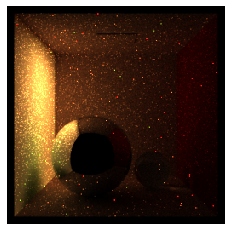

In [5]:
import matplotlib.pyplot as plt
plt.imshow(grad_image * 2.0)
plt.axis('off');

Remapping colors within range: [-2.79, 2.79]


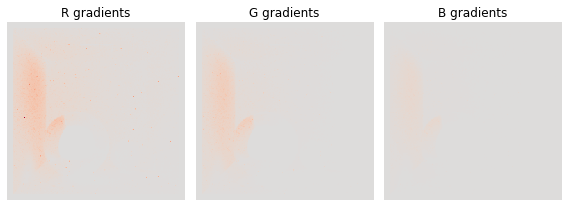

In [6]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

cmap = cm.coolwarm
vlim = dr.max(dr.abs(grad_image))[0]
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

fig, axx = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axx):
    ax.imshow(grad_image[..., i], cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title('RGB'[i] + ' gradients')
    ax.axis('off')
fig.tight_layout()
plt.show()

In [7]:
def get_forward_grad(flag):
    params = mi.traverse(scene)
    
    # Our latent variable
    theta = mi.Float(0.5)
    dr.enable_grad(theta)

    # The wall color now depends on `theta`
    params[key] = mi.Color3f(
        0.2 * theta,
        0.5 * theta,
        0.8 * theta
    )

    # Propagate this change to the scene internal state
    params.update()
    dr.forward(theta, flag | dr.ADFlag.ClearEdges)
    image = mi.render(scene, params, spp=128)

    # Forward-propagate the gradients to the image
    dr.forward_to(image)

    # Visualize the gradient image
    return dr.grad(image)

In [8]:
grad = get_forward_grad(dr.ADFlag.BackPropGrad)
print(grad.max_(), grad.min_())
mi.Bitmap(grad / (grad.max_() - grad.min_()))

[0.5849791169166565] [0.0]


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [9]:
sq_grad_sum = get_forward_grad(dr.ADFlag.BackPropVar)
print(sq_grad_sum.max_(), sq_grad_sum.min_())
mi.Bitmap(sq_grad_sum / (sq_grad_sum.max_() - sq_grad_sum.min_()))

[0.2978067994117737] [0.0]


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [10]:
ones = get_forward_grad(dr.ADFlag.BackPropOnes)
print(ones.max_(), ones.min_())
mi.Bitmap(ones / (ones.max_() - ones.min_()))

[2.924895763397217] [0.0]


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [11]:
var = sq_grad_sum - grad * grad / ones
print(var.max_(), var.min_())
mi.Bitmap(var / (var.max_() - var.min_()))

[4.25719235863653e-07] [-6.016485372128955e-07]


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [12]:
def get_backward_grad(flag):
    params = mi.traverse(scene)
    
    # Our latent variable
    theta = mi.Float(0.5)
    dr.enable_grad(theta)

    # The wall color now depends on `theta`
    params[key] = mi.Color3f(
        0.2 * theta,
        0.5 * theta,
        0.8 * theta
    )

    # Propagate this change to the scene internal state
    params.update()
    image = mi.render(scene, params, spp=512)

    # Backward-propagate the gradients
    dr.backward(image, flag | dr.ADFlag.ClearEdges)

    return dr.grad(theta)

In [13]:
grad_b = get_backward_grad(dr.ADFlag.BackPropGrad)
print(grad_b)

[5032.94775390625]


In [14]:
sq_grad_sum_b = get_backward_grad(dr.ADFlag.BackPropVar)
print(sq_grad_sum_b)

[2518.334228515625]


In [15]:
ones_b = get_backward_grad(dr.ADFlag.BackPropOnes)
print(ones_b)

[13512.876953125]


In [17]:
var_b = sq_grad_sum_b - grad_b * grad_b / ones_b
print(var_b)

[643.7841186523438]
